In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Dataset

## Load Dataset

In [2]:
url = 'https://raw.githubusercontent.com/ferys2195/Dataset/main/timeseries/GercekZamanliTuketim-01072015-30062020.csv'
df = pd.read_csv(url)
len(df)

39456

## Cek Dataset

In [3]:
df.head()

,Date,Time,Consumption Amount (MWh)
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      39456 non-null  object
 1   Time                      39456 non-null  object
 2   Consumption Amount (MWh)  39456 non-null  object
dtypes: object(3)
memory usage: 924.9+ KB


In [5]:
df.isnull().sum()

Date                        0
Time                        0
Consumption Amount (MWh)    0
dtype: int64

## Cleaning Data

### Buat Kolom datetime

Pada dataset terdapat kolom **Date** dan **Time**, untuk menyederhanakan dataset maka gabungkan kedua kolom tersebut menjadi satu kolom

In [6]:
# Menggabungkan kolom 'date' dan 'time' menjadi satu kolom 'datetime'
df['datetime'] = df['Date'] + ' ' + df['Time']

# Menghapus kolom 'date' dan 'time' yang sudah digabung
df = df.drop(['Date', 'Time'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Consumption Amount (MWh)  39456 non-null  object
 1   datetime                  39456 non-null  object
dtypes: object(2)
memory usage: 616.6+ KB


### Buat variabel untuk mengatur dataset

In [7]:
time = "datetime"
series = "Consumption Amount (MWh)"

### Ubah Type Data Pada Dataset

In [8]:
df[time]=pd.to_datetime(df[time])
df[series] = df[series].apply(lambda x: x.split(',')[0]).astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Consumption Amount (MWh)  39456 non-null  float64       
 1   datetime                  39456 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 616.6 KB


### Mengatur Index Dataset

In [10]:
df.set_index(time, inplace=True)

In [11]:
df = df.sort_index()

In [12]:
df.head()

,Consumption Amount (MWh)
datetime,
2015-12-31 00:00:00,29.590
2015-12-31 01:00:00,27.785
2015-12-31 02:00:00,26.516
2015-12-31 03:00:00,26.091
2015-12-31 04:00:00,25.871


### Tampilkan Dataset pada grafik

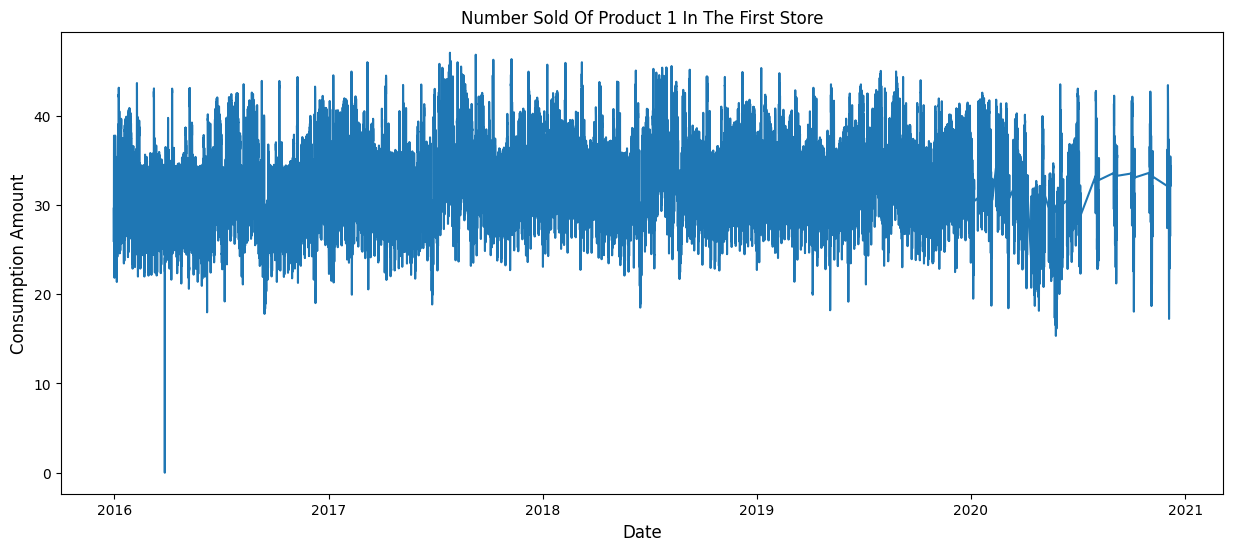

In [13]:
plt.figure(figsize = (15, 6))
plt.plot(df)
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Consumption Amount', {'fontsize': 12})
plt.title('Number Sold Of Product 1 In The First Store')
plt.show()

### Tampung Dataset pada Variabel Baru

In [14]:
dataset = pd.DataFrame(df[series])
data = dataset.values

data.shape

(39456, 1)

### Normalisasi Dataset

In [15]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

### Mengatur Nilai X dan Y Dataset

In [16]:
x = []
y = []
time_steps = 60

for i in range(time_steps, len(scaled_data)):
    x.append(scaled_data[i-time_steps:i, :1])
    y.append(scaled_data[i, :1])

In [17]:
x, y = np.array(x), np.array(y)

### Split Dataset Menjadi Train (80%) dan Test (20%)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
x_train.shape , y_train.shape

((31516, 60, 1), (31516, 1))

In [21]:
print(len(x_train), len(x_test))

31516 7880


# Model

## Buat Model Sequential

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape= (x_train.shape[1], 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

## Membangun Optimizer Model menggunakan Learning Rate

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## Print Nilai Mae dibawah 10%

In [24]:
threshold_mae = (x_train.max() - x_train.min()) * 10/100
print(f"Nilai minimal mae di bawah 10% : {threshold_mae}")

Nilai minimal mae di bawah 10% : 0.1


## Buat Callback Model

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      self.model.stop_training = True
      print("\nMAE dari model tercapai < 10% dari skala data")
callbacks = myCallback()

## Mengatur Float menjadi Float64

In [26]:
tf.keras.backend.set_floatx('float64')

## Latih Model

In [27]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=100, steps_per_epoch=25, callbacks=[callbacks], verbose=2)

Epoch 1/100
25/25 - 13s - loss: 0.2307 - mae: 0.6699 - val_loss: 0.1775 - val_mae: 0.5852 - 13s/epoch - 518ms/step
Epoch 2/100
25/25 - 2s - loss: 0.1488 - mae: 0.5335 - val_loss: 0.1057 - val_mae: 0.4466 - 2s/epoch - 69ms/step
Epoch 3/100
25/25 - 1s - loss: 0.0884 - mae: 0.4061 - val_loss: 0.0615 - val_mae: 0.3336 - 1s/epoch - 55ms/step
Epoch 4/100
25/25 - 2s - loss: 0.0522 - mae: 0.3048 - val_loss: 0.0358 - val_mae: 0.2461 - 2s/epoch - 69ms/step
Epoch 5/100
25/25 - 2s - loss: 0.0311 - mae: 0.2267 - val_loss: 0.0214 - val_mae: 0.1813 - 2s/epoch - 69ms/step
Epoch 6/100
25/25 - 2s - loss: 0.0192 - mae: 0.1691 - val_loss: 0.0135 - val_mae: 0.1372 - 2s/epoch - 71ms/step
Epoch 7/100
25/25 - 1s - loss: 0.0126 - mae: 0.1316 - val_loss: 0.0094 - val_mae: 0.1109 - 1s/epoch - 55ms/step
Epoch 8/100
25/25 - 1s - loss: 0.0091 - mae: 0.1105 - val_loss: 0.0072 - val_mae: 0.0976 - 1s/epoch - 54ms/step
Epoch 9/100

MAE dari model tercapai < 10% dari skala data
25/25 - 1s - loss: 0.0072 - mae: 0.0992 - 

# Output Pelatihan Model

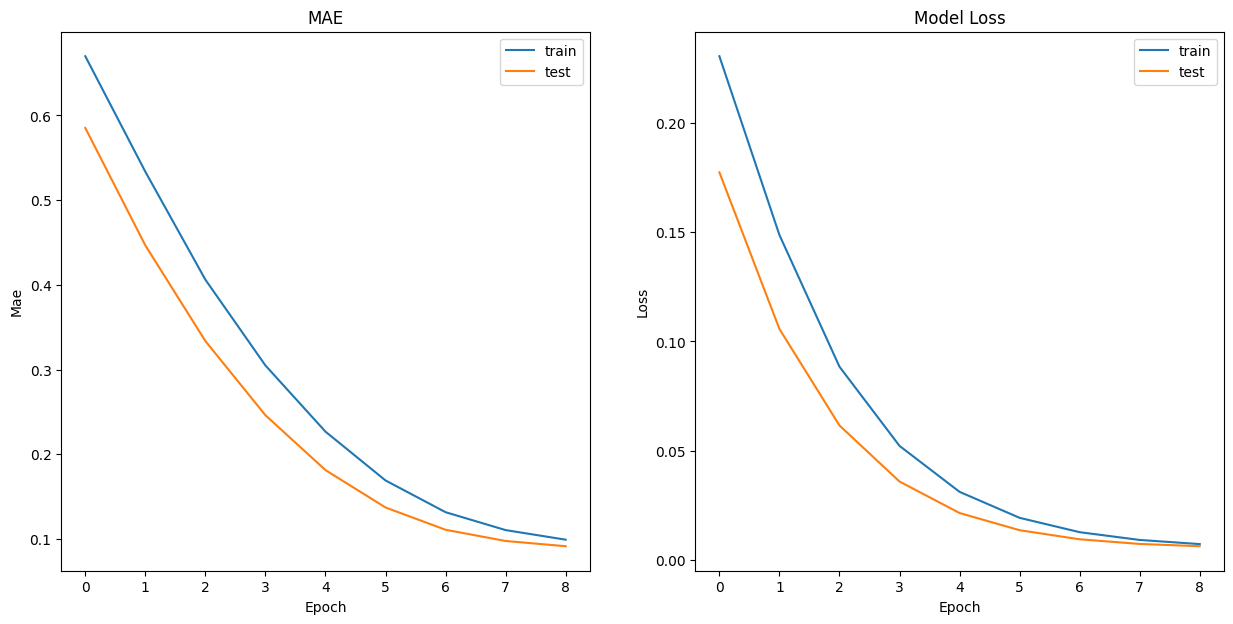

In [28]:
# Membuat subplot dengan lebar yang berbeda
fig, axs = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1]})

# Plot MAE di subplot pertama
axs[0].plot(history.history['mae'])
axs[0].plot(history.history['val_mae'])
axs[0].set_title('MAE')
axs[0].set_ylabel('Mae')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

# Plot Loss di subplot kedua
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'test'], loc='upper right')

plt.show()